# BTCUSDT Analysis
In this file I will deal with the historical analysis of BTCUSDT using market indicators, statistical methods and machine learning techniques to create an operational strategy

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

plt.style.use('seaborn-whitegrid')

In [2]:
import sys
sys.path.insert(0, r"C:\Users\axeli\Desktop\Github\crypto-trading\Scraping")

## Updating Files
Use the crypto scraper extension to update the datasets

In [3]:
f_list = [
    r"C:\Users\axeli\Desktop\Github\crypto-trading\Data Analysis\CSV\BTCUSDT 5.csv",
    r"C:\Users\axeli\Desktop\Github\crypto-trading\Data Analysis\CSV\BTCUSDT 15.csv"
]

In [4]:
import crypto_scraper as cs
from pybit import usdt_perpetual

session_unauth = usdt_perpetual.HTTP(
    endpoint="https://api-testnet.bybit.com"
)

bybit_scr = cs.ByBit_Scraper(session_unauth)

for f in f_list:
    bybit_scr.set_dataframe(pd.read_csv(f))
    bybit_scr.update_history()
    bybit_scr.to_csv(f)

BTCUSDT Starting Updating ...
	Extraction Time: 2022-10-10 11:35:00
Ending Updating ...
Creating .csv file ...
BTCUSDT Starting Updating ...
	Extraction Time: 2022-10-10 11:45:00
Ending Updating ...
Creating .csv file ...


## Exploratory Data Analysis - BTCUSDT 15
After updating our datasets we can explorate our time serie

In [5]:
btc15 = pd.read_csv(f_list[1])
btc15

,symbol,period,start_at,datetime,open,high,low,close
0,BTCUSDT,15,1581938100,2020-02-17 11:15:00,9632.88,9658.14,9629.56,9658.14
1,BTCUSDT,15,1581939000,2020-02-17 11:30:00,9658.14,9701.11,9588.07,9604.98
2,BTCUSDT,15,1581939900,2020-02-17 11:45:00,9604.98,9640.91,9583.22,9600.32
3,BTCUSDT,15,1581940800,2020-02-17 12:00:00,9600.32,9648.28,9579.85,9613.43
4,BTCUSDT,15,1581941700,2020-02-17 12:15:00,9613.43,9656.98,9611.24,9643.22
...,...,...,...,...,...,...,...,...
92799,BTCUSDT,15,1665405900,2022-10-10 12:45:00,19416.33,19435.56,19373.24,19418.01
92800,BTCUSDT,15,1665406800,2022-10-10 13:00:00,19418.01,19438.36,19390.50,19397.97
92801,BTCUSDT,15,1665407700,2022-10-10 13:15:00,19397.97,19413.00,19381.48,19385.33
92802,BTCUSDT,15,1665408600,2022-10-10 13:30:00,19385.33,19408.17,19344.34,19401.66


In [6]:
# The first step is to reshape the dataset
btc15 = btc15.iloc[:, 3:].set_index('datetime')
btc15

,open,high,low,close
datetime,,,,
2020-02-17 11:15:00,9632.88,9658.14,9629.56,9658.14
2020-02-17 11:30:00,9658.14,9701.11,9588.07,9604.98
2020-02-17 11:45:00,9604.98,9640.91,9583.22,9600.32
2020-02-17 12:00:00,9600.32,9648.28,9579.85,9613.43
2020-02-17 12:15:00,9613.43,9656.98,9611.24,9643.22
...,...,...,...,...
2022-10-10 12:45:00,19416.33,19435.56,19373.24,19418.01
2022-10-10 13:00:00,19418.01,19438.36,19390.50,19397.97
2022-10-10 13:15:00,19397.97,19413.00,19381.48,19385.33


In [7]:
# Let's check basic informations
print(btc15.info(), '\n', btc15.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 92804 entries, 2020-02-17 11:15:00 to 2022-10-10 13:45:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    92804 non-null  float64
 1   high    92804 non-null  float64
 2   low     92804 non-null  float64
 3   close   92804 non-null  float64
dtypes: float64(4)
memory usage: 3.5+ MB
None 
                open          high           low         close
count  92804.000000  92804.000000  92804.000000  92804.000000
mean   30782.982885  30864.717953  30699.799977  30783.088820
std    17272.338322  17319.169016  17224.841876  17272.239084
min     3881.730000   4242.120000   3793.730000   3881.730000
25%    11861.577500  11876.185000  11843.865000  11861.670000
50%    31751.040000  31860.440000  31649.280000  31751.040000
75%    44991.665000  45129.980000  44834.785000  44991.665000
max    68751.930000  69031.900000  68595.550000  68751.930000


In [8]:
# Perfect! There are no null values.
# Now we see the type of values with which we are going to operate
btc15.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

## Find a Strategy
After checking the integrity of the data we move on to extrapolating data to create a strategy
### Analyze Candles

In [9]:
btc15['perc_ret'] = btc15['close']/btc15['open'] - 1        # Candle Percentage Return
btc15['log_ret'] = np.log(btc15['close']/btc15['open'])     # Candle Logarithmic Return
btc15

,open,high,low,close,perc_ret,log_ret
datetime,,,,,,
2020-02-17 11:15:00,9632.88,9658.14,9629.56,9658.14,0.002622,0.002619
2020-02-17 11:30:00,9658.14,9701.11,9588.07,9604.98,-0.005504,-0.005519
2020-02-17 11:45:00,9604.98,9640.91,9583.22,9600.32,-0.000485,-0.000485
2020-02-17 12:00:00,9600.32,9648.28,9579.85,9613.43,0.001366,0.001365
2020-02-17 12:15:00,9613.43,9656.98,9611.24,9643.22,0.003099,0.003094
...,...,...,...,...,...,...
2022-10-10 12:45:00,19416.33,19435.56,19373.24,19418.01,0.000087,0.000087
2022-10-10 13:00:00,19418.01,19438.36,19390.50,19397.97,-0.001032,-0.001033
2022-10-10 13:15:00,19397.97,19413.00,19381.48,19385.33,-0.000652,-0.000652


In [10]:
import scipy.stats as stats

density = stats.gaussian_kde(btc15['log_ret'])

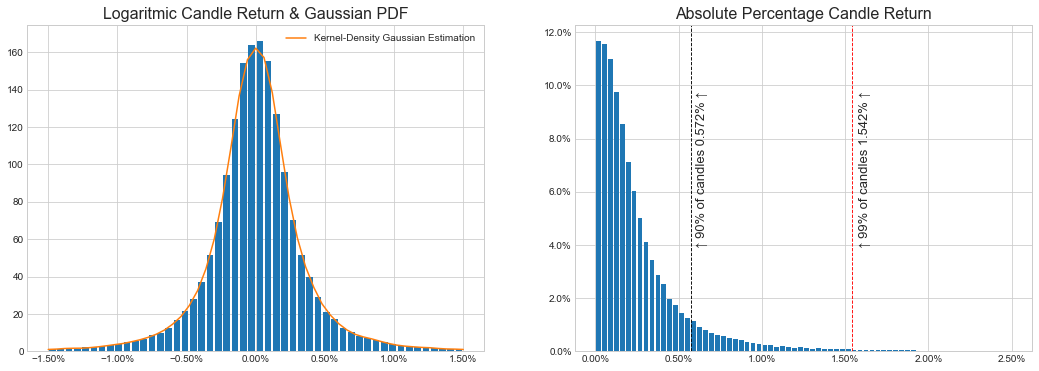

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Logarithmic Return Analysis
axs[0].set_title("Logaritmic Candle Return & Gaussian PDF", fontsize = 16)
n, x, _ = axs[0].hist(btc15['log_ret'], bins = 50, rwidth = 0.8,
         range = (-0.015, 0.015), density = True)
axs[0].plot(x, density(x), label = "Kernel-Density Gaussian Estimation")
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs[0].legend()

# Absolute Percentage Return Analysis
axs[1].set_title("Absolute Percentage Candle Return", fontsize = 16)
axs[1].hist(np.abs(btc15['perc_ret']), bins = 70, rwidth = 0.8, range = (0, 0.025),
           weights=np.ones_like(btc15['perc_ret']) / len(btc15['perc_ret']))
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


perc_90 = np.percentile(btc15['perc_ret'].abs(), 90)
perc_99 = np.percentile(btc15['perc_ret'].abs(), 99)
axs[1].axvline(x = perc_90, color = 'black', linestyle = '--', linewidth = 0.9)
axs[1].text(perc_90*1.06, 0.04, f"↑ 90% of candles {round(perc_90*100, 3)}% ↑", rotation = 90, fontsize = 13)
axs[1].axvline(x = perc_99, color = 'red', linestyle = '--', linewidth = 0.9)
axs[1].text(perc_99*1.025, 0.04, f"↑ 99% of candles {round(perc_99*100, 3)}% ↑", rotation = 90, fontsize = 13)

plt.show();

### Indicators and other informations
We derive the indicators and other information from the data available

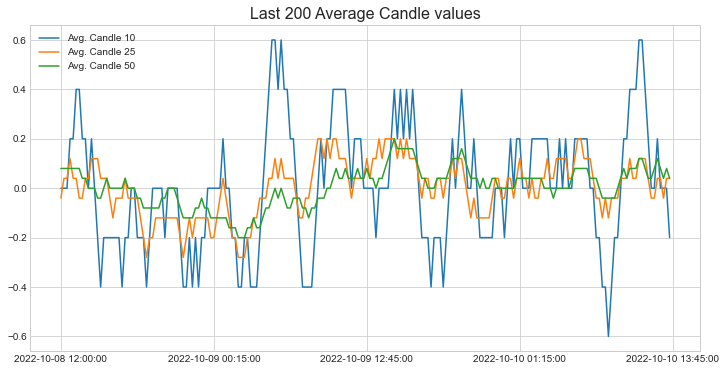

In [12]:
btc15_ind = pd.DataFrame(index = btc15.index) # Create a DataFrame for all the indicators

# Define the candle type (1 = Buy, -1 = Sell)
btc15_ind['candle'] = np.where(btc15['close'] >= btc15['open'], 1, -1)

# Rolling Statistics - Average Candle Type
btc15_ind['avg_cand_10'] = btc15_ind['candle'].rolling(10).mean() # 10 Periods
btc15_ind['avg_cand_25'] = btc15_ind['candle'].rolling(25).mean() # 25 Periods
btc15_ind['avg_cand_50'] = btc15_ind['candle'].rolling(50).mean() # 50 periods

# Plot last 200 values
plt.figure(figsize = (12, 6))

labels = [btc15_ind[-200:].index[int(i)-1] for i in np.linspace(1, len(btc15_ind[-200:].index), 5)]
pos = [int(x) for x in np.linspace(0, len(btc15_ind[-200:].index), 5)]
plt.xticks(pos, labels)

plt.title("Last 200 Average Candle values", fontsize = 16)
plt.plot(btc15_ind['avg_cand_10'][-200:], label = "Avg. Candle 10")
plt.plot(btc15_ind['avg_cand_25'][-200:], label = "Avg. Candle 25")
plt.plot(btc15_ind['avg_cand_50'][-200:], label = "Avg. Candle 50")

plt.legend()
plt.show()

In [13]:
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator

periods = [4, 8, 12, 24, 48, 96]

for p in periods:
    btc15_ind[f'SMA_{p}'] = SMAIndicator(btc15['close'], p).sma_indicator()
    btc15_ind[f'EMA_{p}'] = EMAIndicator(btc15['close'], p).ema_indicator()

btc15_ind

,candle,avg_cand_10,avg_cand_25,avg_cand_50,SMA_4,EMA_4,SMA_8,EMA_8,SMA_12,EMA_12,SMA_24,EMA_24,SMA_48,EMA_48,SMA_96,EMA_96
datetime,,,,,,,,,,,,,,,,
2020-02-17 11:15:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 11:30:00,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 11:45:00,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 12:00:00,1,NaN,NaN,NaN,9619.2175,9618.724160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 12:15:00,1,NaN,NaN,NaN,9615.4875,9628.522496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10 12:45:00,1,0.2,0.04,0.12,19393.9325,19400.990313,19389.36375,19384.001801,19365.034167,19372.728834,19344.832500,19365.983755,19387.801458,19378.671216,19415.364792,19399.530285
2022-10-10 13:00:00,-1,0.0,0.04,0.08,19398.8500,19399.782188,19394.92750,19387.105846,19370.698333,19376.612091,19342.997917,19368.542655,19387.040417,19379.458922,19414.347604,19399.498114
2022-10-10 13:15:00,-1,0.0,-0.04,0.04,19404.4100,19394.001313,19393.53625,19386.711213,19377.778333,19377.953307,19340.657500,19369.885643,19385.969167,19379.698557,19413.955208,19399.205988


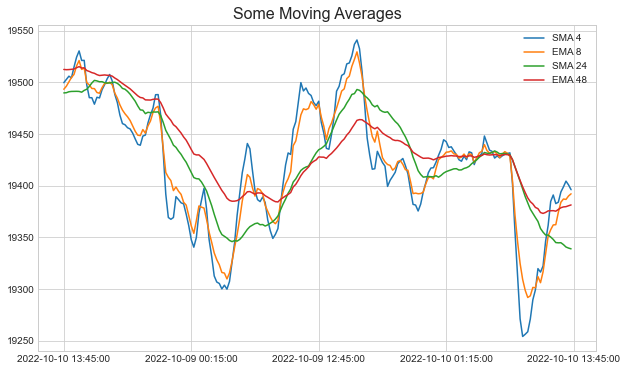

In [14]:
plt.figure(figsize = (10, 6))

labels = [btc15_ind[-200:].index[int(i)-1] for i in np.linspace(0, len(btc15_ind[-200:].index), 5)]
pos = [int(x) for x in np.linspace(0, len(btc15_ind[-200:].index), 5)]

plt.xticks(pos, labels)

plt.title("Some Moving Averages", fontsize = 16)

for ma in btc15_ind.columns[4::3]:
    plt.plot(btc15_ind[ma][-200:], label = ma.replace('_', ' '))

plt.legend()
plt.show()

### Position relative to the moving averages
Use previous values of Moving Averages to find patterns in the dataset. We need to extract the data from the dataframe of indicators first

In [15]:
# A function to identify the position of the candle relative to
# the previous MA value and the kind of candle (Buy or Sell)

def candle_position(candle_df, ma_df):
    
    ma_df = ma_df.shift(1) # Shift MA
    ma_pos_df = pd.DataFrame(index = ma_df.index)
    
    for ma in ma_df.columns:
        ma_pos_df[ma + '_pos'] = np.where(ma_df[ma].isna(), pd.NA,
                                          np.where(candle_df['open'] > ma_df[ma],
                                                   np.where(candle_df['close'] > candle_df['open'], 'Above Buy', 'Above Sell'),
                                                   np.where(candle_df['close'] > candle_df['open'], 'Below Buy', 'Below Sell')))
    return ma_pos_df

def candle_position_freq(ma_pos_df):
    
    ma_pos_freq = {}
    
    for ma in ma_pos_df.columns:
        freq = {}
        for pos in ['Above', 'Below']:
            pos_serie = ma_pos_df[ma].loc[ma_pos_df[ma].str.contains(pos)]
            for t in ['Buy', 'Sell']:
                #print(round(pos_serie.str.contains(t).mean(), 5))
                freq[f'{pos} {t}'] = round(pos_serie.str.contains(t).mean(), 5)
            
        ma_pos_freq[ma.replace('_pos', '')] = freq
    
    return ma_pos_freq

In [16]:
btc15_ma_pos = candle_position(btc15, btc15_ind.iloc[:, 4:]).dropna()
btc15_ma_pos_freq = candle_position_freq(btc15_ma_pos)

After collecting the data, let's start with compare the results of the candle position analysis!

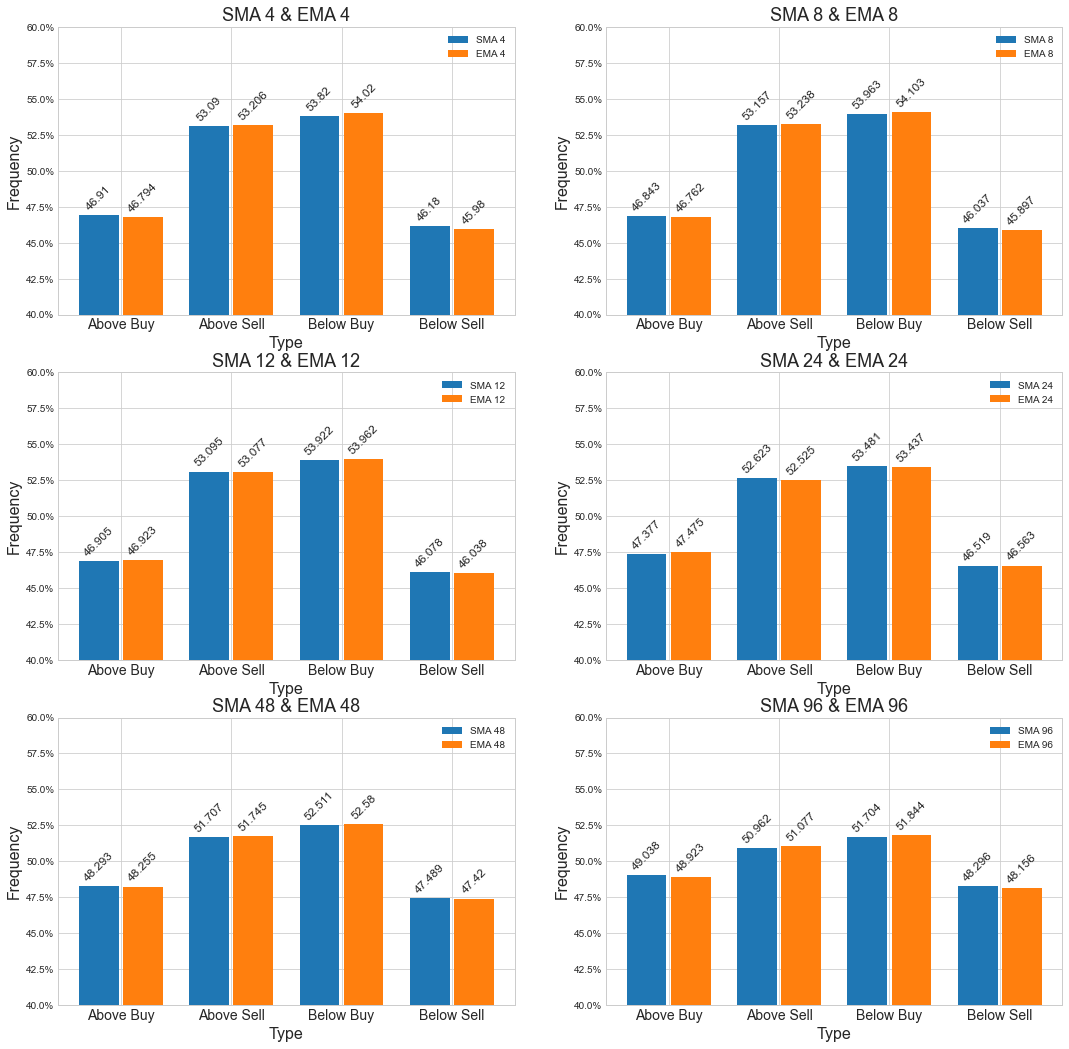

In [17]:
# Comparison between periods
fig, axs = plt.subplots(nrows= 3, ncols=2, figsize=(18, 18))

keys = list(btc15_ma_pos_freq.keys())
x = np.arange(4)
width = 0.40

for n in range(6):
    sma_rect = axs[n // 2][n % 2].bar(x - width/2, [round(x*100, 3) for x in btc15_ma_pos_freq[keys[n*2]].values()],
                          width*0.9, label = keys[n*2].replace('_', ' '))
    ema_rect = axs[n // 2][n % 2].bar(x + width/2, [round(x*100, 3) for x in btc15_ma_pos_freq[keys[n*2+1]].values()],
                          width*0.9, label = keys[n*2 + 1].replace('_', ' '))
    
    
    axs[n // 2][n % 2].set_xlabel('Type', fontsize = 16)
    axs[n // 2][n % 2].set_ylabel('Frequency', fontsize = 16)
    axs[n // 2][n % 2].set_title(f"{keys[n*2].replace('_', ' ')} & {keys[n*2 +1].replace('_', ' ')}", fontsize = 18)
    
    axs[n // 2][n % 2].bar_label(sma_rect, padding=3, rotation = 45, fontsize = 12)
    axs[n // 2][n % 2].bar_label(ema_rect, padding=3, rotation = 45, fontsize = 12)

    axs[n // 2][n % 2].set_xticks(x, btc15_ma_pos_freq[keys[n*2+1]].keys(), fontsize = 14)
    axs[n // 2][n % 2].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[n // 2][n % 2].set_ylim([40, 60])
    
    axs[n // 2][n % 2].legend()

plt.show()

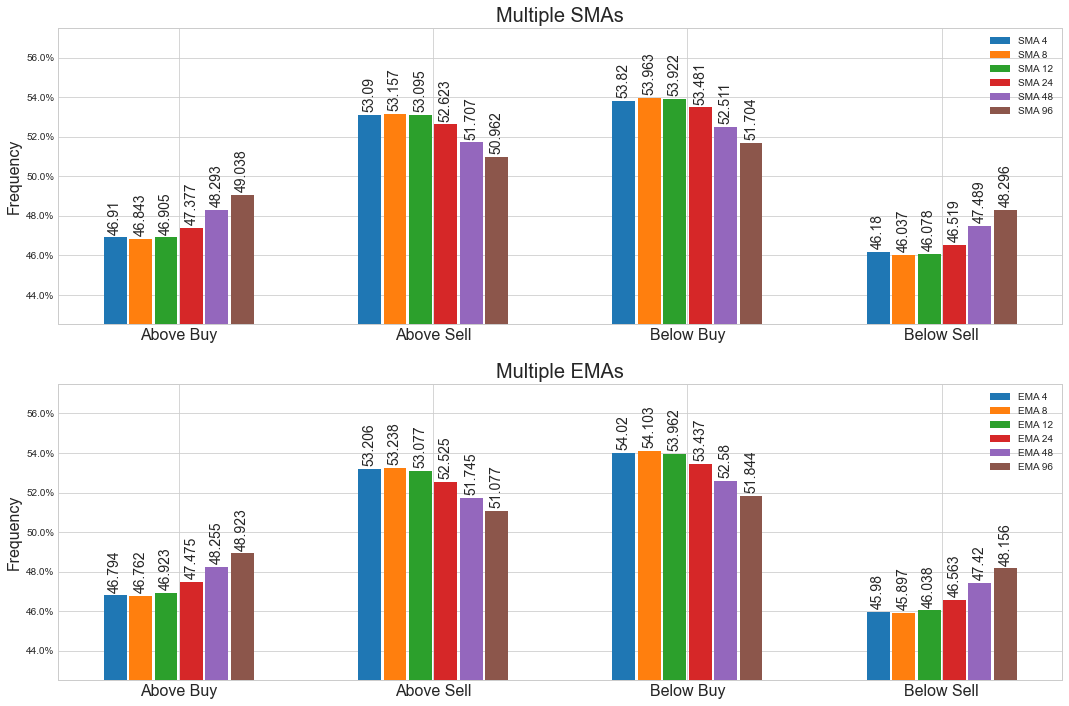

In [18]:
# SMAs and EMAs comparasion
fig, axs = plt.subplots(nrows= 2, ncols=1, figsize=(18, 12))

keys = list(btc15_ma_pos_freq.keys())
x = np.arange(4)
width = 0.1

for n in range(2):
    
    for i in range(6):
        rect = axs[n].bar(x + (i*2-5)*width/2, [round(x*100, 3) for x in btc15_ma_pos_freq[keys[i*2+n]].values()],
                              width*0.9, label = keys[i*2+n].replace('_', ' '))
        axs[n].bar_label(rect, padding=3, rotation = 90, fontsize = 14)
    
    axs[n].set_title(f"Multiple {keys[i*2+n].split('_')[0]}s", fontsize = 20)
    axs[n].set_ylabel('Frequency', fontsize = 16)
    
    axs[n].set_xticks(x, btc15_ma_pos_freq[keys[0+n]].keys(), fontsize = 16)
    axs[n].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[n].set_ylim([42.5, 57.5])
    
    axs[n].legend()
    

plt.show()

From the results we can see that we can create a mean reverting strategy using the EMA(8). So buy when the open is below the EMA(8) value of the previous candle (it would work 54.096% of time) and sell when the open is above the EMA(8) value of the previous candle (it would work 53.231% of time).

### Strategy Backtest
Now let's make a little backtest of the strategy

In [19]:
bt_buy_ret = btc15['perc_ret'].loc[btc15['open'] < btc15_ind['EMA_8'].shift(1)]
bt_sell_ret = btc15['perc_ret'].loc[btc15['open'] > btc15_ind['EMA_8'].shift(1)]*-1
bt_fin_ret = pd.concat([bt_buy_ret, bt_sell_ret])

bt_buy = np.cumprod(bt_buy_ret + 1)
bt_sell = np.cumprod(bt_sell_ret + 1)
bt_fin = np.cumprod(bt_fin_ret + 1)

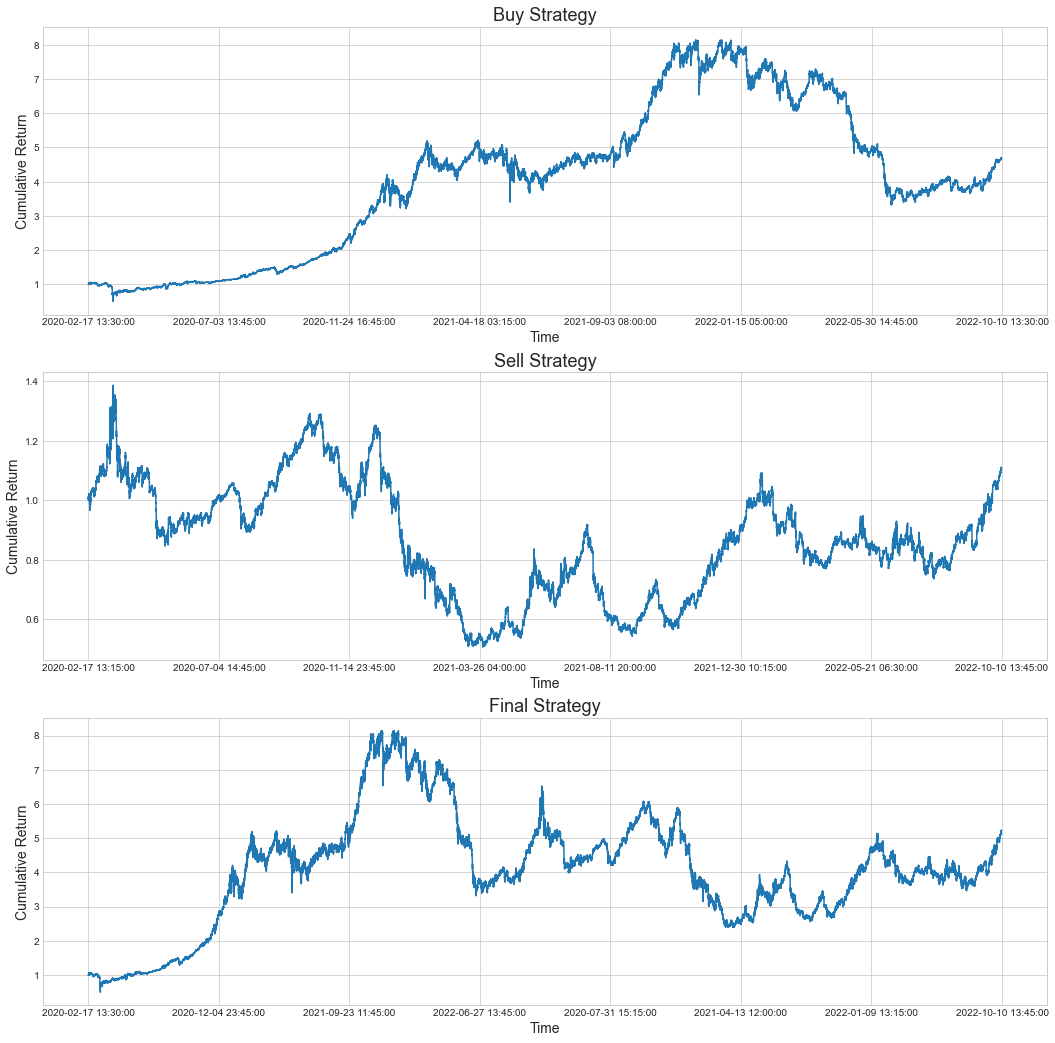

In [20]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (18, 18))

bt_names = ['Buy Strategy', 'Sell Strategy', 'Final Strategy']

for i, bt in zip(range(3), [bt_buy, bt_sell, bt_fin]):
    
    labels = [bt.index[int(i)-1] for i in np.linspace(1, len(bt.index), 8)]
    pos = [int(x) for x in np.linspace(1, len(bt.index), 8)]
    axs[i].set_xticks(pos, labels)
    
    axs[i].set_title(bt_names[i], fontsize = 18)
    axs[i].set_xlabel('Time', fontsize = 14)
    axs[i].set_ylabel('Cumulative Return', fontsize = 14)
    
    axs[i].plot(bt)

Comparing the results of the backtest we can see that the "Sell Strategy" does not show excellent results, while the "Buy Strategy" has a good cumulate return, but in the last period the performance is not so good. So we have one question, how can we improve the performance? Using Machine Learning!

## Performance Improvement with Machine Learning
In this section we will use machine learning algorithms to improve the performance of our strategy. Let's start with adding other indicators to the Indicators DataFrame

### RSI

In [21]:
# Add RSI
from ta.momentum import RSIIndicator

periods = [7, 14, 28]

for p in periods:
    btc15_ind[f'RSI_{p}'] = RSIIndicator(btc15['close'], p).rsi()

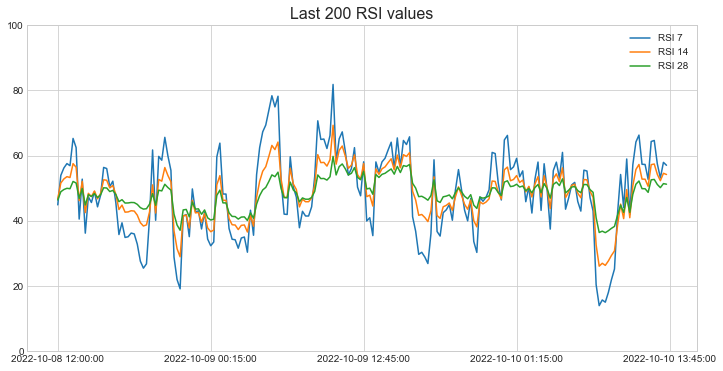

In [22]:
# Plot last 200 values
plt.figure(figsize = (12, 6))

labels = [btc15_ind[-200:].index[int(i)-1] for i in np.linspace(1, len(btc15_ind[-200:].index), 5)]
pos = [int(x) for x in np.linspace(0, len(btc15_ind[-200:].index), 5)]
plt.xticks(pos, labels)

plt.title("Last 200 RSI values", fontsize = 16)
for p in periods:
    plt.plot(btc15_ind[f'RSI_{p}'][-200:], label = f"RSI {p}")

plt.ylim((0, 100))
plt.legend()
plt.show()

### Ulcer Index

In [23]:
# Add Ulcer Index
from ta.volatility import UlcerIndex

periods = [7, 14, 28]

for p in periods:
    btc15_ind[f'UI_{p}'] = UlcerIndex(btc15['close'], p).ulcer_index()

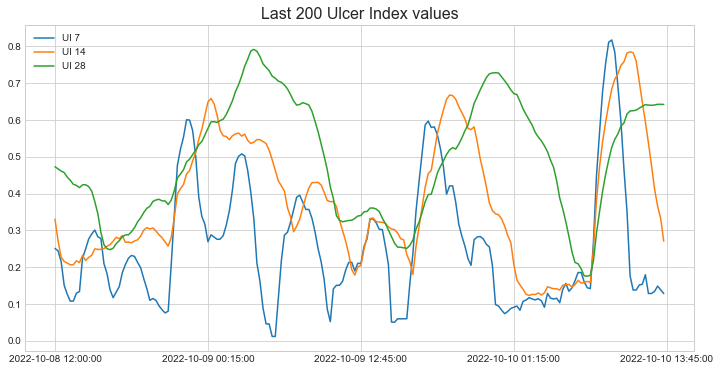

In [24]:
# Plot last 200 values
plt.figure(figsize = (12, 6))

labels = [btc15_ind[-200:].index[int(i)-1] for i in np.linspace(1, len(btc15_ind[-200:].index), 5)]
pos = [int(x) for x in np.linspace(0, len(btc15_ind[-200:].index), 5)]
plt.xticks(pos, labels)

plt.title("Last 200 Ulcer Index values", fontsize = 16)
for p in periods:
    plt.plot(btc15_ind[f'UI_{p}'][-200:], label = f"UI {p}")

plt.legend()
plt.show()

### Mass Index

In [25]:
# Add Mass Index
from ta.trend import MassIndex

btc15_ind[f'MI_9_25'] = MassIndex(btc15['high'], btc15['low']).mass_index()

In [26]:
btc15_ind.describe()

,candle,avg_cand_10,avg_cand_25,avg_cand_50,SMA_4,EMA_4,SMA_8,EMA_8,SMA_12,EMA_12,...,EMA_48,SMA_96,EMA_96,RSI_7,RSI_14,RSI_28,UI_7,UI_14,UI_28,MI_9_25
count,92804.000000,92795.000000,92780.000000,92755.000000,92801.000000,92801.000000,92797.000000,92797.000000,92793.000000,92793.000000,...,92757.000000,92709.000000,92709.000000,92798.000000,92791.000000,92777.000000,92798.000000,92791.000000,92777.000000,92764.000000
mean,0.007607,0.007621,0.007626,0.007625,30783.614744,30783.614915,30784.316166,30784.316652,30785.018022,30785.019257,...,30791.342490,30799.758746,30799.750182,50.588285,50.556987,50.501027,0.552188,0.866681,1.306760,24.918747
std,0.999976,0.279514,0.173033,0.122708,17271.853142,17271.670231,17271.455386,17271.079664,17271.074533,17270.514104,...,17265.564155,17263.458996,17259.086124,15.571204,11.376081,8.441363,0.626243,0.911882,1.269760,1.498771
min,-1.000000,-1.000000,-0.680000,-0.440000,4203.967500,4205.535137,4414.996250,4399.144842,4537.225833,4570.443243,...,4871.702996,4962.288646,5002.438488,0.028734,1.968163,11.809859,0.000000,0.000000,0.052802,3.627167
25%,-1.000000,-0.200000,-0.120000,-0.080000,11860.307500,11860.748916,11859.487500,11857.970563,11854.710833,11855.302054,...,11851.939604,11848.458229,11842.455106,40.185117,43.429065,45.469361,0.201850,0.334168,0.531312,23.949452
50%,1.000000,0.000000,0.040000,0.000000,31744.272500,31748.002548,31739.275000,31744.760653,31738.845000,31753.094105,...,31769.835064,31785.861562,31853.355831,50.779009,50.693410,50.509898,0.367704,0.590409,0.916569,24.852729
75%,1.000000,0.200000,0.120000,0.080000,45003.805000,44992.511340,44999.651250,44993.040808,45014.733333,45003.520185,...,45112.539250,45152.894479,45241.317570,61.041334,57.600848,55.483358,0.671110,1.062932,1.629945,25.824047
max,1.000000,1.000000,1.000000,0.880000,68653.885000,68659.979096,68626.290000,68588.888583,68552.413333,68478.832968,...,67761.211853,67589.685729,67450.178275,98.013179,94.437775,88.058660,16.061812,21.482799,20.230648,33.023075


# Optimization with Machine Learning
## Buy Strategy
We will try to improve the buy strategy only using the values of the oscillators of the previous 2 candles

In [27]:
# Define a complexive DataFrame
btc15_ind_1s = btc15_ind.iloc[:, [1, 2, 3, -7, -6,-5, -4, -3, -2, -1]].shift(1).rename(columns = lambda x: x + "_1s")
btc15_ind_2s = btc15_ind.iloc[:, [1, 2, 3, -7, -6,-5, -4, -3, -2, -1]].shift(2).rename(columns = lambda x: x + "_2s")
btc15_ind_3s = btc15_ind.iloc[:, [1, 2, 3, -7, -6,-5, -4, -3, -2, -1]].shift(2).rename(columns = lambda x: x + "_3s")
ml_df = pd.concat([btc15, btc15_ind['candle'], btc15_ind_1s, btc15_ind_2s, btc15_ind_3s], axis = 1)
ml_df.columns

Index(['open', 'high', 'low', 'close', 'perc_ret', 'log_ret', 'candle',
       'avg_cand_10_1s', 'avg_cand_25_1s', 'avg_cand_50_1s', 'RSI_7_1s',
       'RSI_14_1s', 'RSI_28_1s', 'UI_7_1s', 'UI_14_1s', 'UI_28_1s',
       'MI_9_25_1s', 'avg_cand_10_2s', 'avg_cand_25_2s', 'avg_cand_50_2s',
       'RSI_7_2s', 'RSI_14_2s', 'RSI_28_2s', 'UI_7_2s', 'UI_14_2s', 'UI_28_2s',
       'MI_9_25_2s', 'avg_cand_10_3s', 'avg_cand_25_3s', 'avg_cand_50_3s',
       'RSI_7_3s', 'RSI_14_3s', 'RSI_28_3s', 'UI_7_3s', 'UI_14_3s', 'UI_28_3s',
       'MI_9_25_3s'],
      dtype='object')

In [28]:
from sklearn.model_selection import train_test_split

X = ml_df.loc[ml_df['open'] < btc15_ind['EMA_8'].shift(1)].dropna().iloc[:, 7:]
y = np.where(ml_df.loc[ml_df['open'] < btc15_ind['EMA_8'].shift(1)].dropna().iloc[:, 6] == -1, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [29]:
# Let's define the benchmark
y.mean()

0.5422679951744783

### Random Forest
Let's start with a simple Random Forest Classifier combined with a GridSearchCv to find the best hyperparameters

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 6, 8],
    'max_features': ['sqrt'],
    'min_samples_leaf': [0.05, 0.1, 0.15],
    'n_estimators': [500, 1000]
}

# Model fitting
forest_clf = RandomForestClassifier()
grid_src = GridSearchCV(forest_clf, param_grid, cv = 3, n_jobs = -1, verbose = 10)
grid_src.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 6, 8],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [0.05, 0.1, 0.15],
                         'n_estimators': [500, 1000]},
             verbose=10)

In [31]:
# Let's take a look to the best hyperparameters
grid_src.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.05,
 'n_estimators': 1000}

In [32]:
# Select the best estimator
best_forest_clf = grid_src.best_estimator_

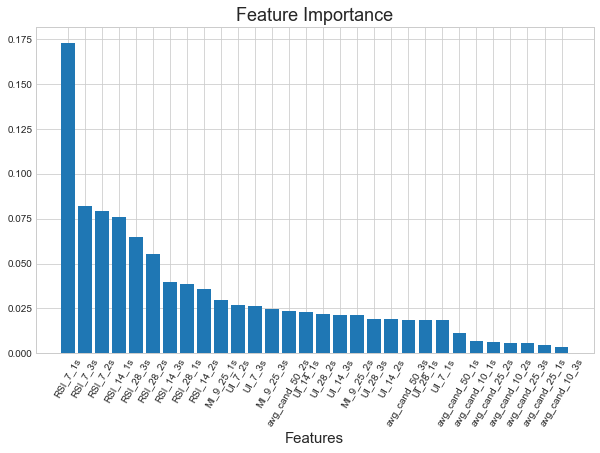

In [33]:
# Plot the feature importance for the best estimator
fi_dict = {X_train.columns[i]: best_forest_clf.feature_importances_[i] for i in range(len(X_train.columns))} # Create the dictionary
fi_dict = {k: v for k, v in sorted(fi_dict.items(), key = lambda item: item[1], reverse = True)} # Order the dictionary

plt.figure(figsize = (10, 6))
importances = plt.bar(fi_dict.keys(), fi_dict.values())

plt.title("Feature Importance", fontsize = 18)
plt.xlabel('Features', fontsize = 15)

plt.xticks(rotation = 60)
plt.show()

In [34]:
# Let's check the Random Forest performance
best_forest_clf.score(X_test, y_test)

0.5375851669831342

## Conclusion
As we can see the implementation of a Machine Learning model does not lead to better results, this means that the mean reverting strategy based on this simple criterion is the best choice!
#### Final Observations
Despite the winrate of 54.22%, to create a correct simulation there is a need to create a simulator that also takes into account the commissions per single order and the spread.